In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../ipa/src/')
import preprocessing_utils as pre
import localization_utils as loc
import detection_utils as det
import nd2
import correction_utils as cor
import stackview
from glob import glob
from tqdm import tqdm
import seaborn as sns

# Open the image

In [14]:
path="/tungstenfs/scratch/ggiorget/nessim/microscopy_data/20240425/beads/ND_Acquisition/20240425_B2_100ms_7%laser_nd009.nd2"
im = nd2.imread(path)
met = nd2.ND2File(path)
print(im.shape)
im=im[:,1:3,:,:]
print(im.shape)
stackview.slice(im[:,1,...], continuous_update=True)

(21, 4, 976, 976)
(21, 2, 976, 976)


In [15]:
df = pd.DataFrame(met.events())
df['dt'] = df['Time [s]'].diff()
df.dt.mean()


0.6008175537109375

# Detect the beads

In [16]:
im_c1 = im[:, 0, ...]
im_c2 = im[:, 1, ...]

In [17]:
n_detections=[]

for t in np.arange(0.1,0.9,0.01):
    n_detections.append(len(pre.get_loc(im=im_c1,frame = im_c1.shape[0]//2,thresh=t,mins=1.974,maxs=3)))
    #h = pre.compute_h_param(im=im_c1,frame = im_c1.shape[0]//2,thresh=0.5)
    #h2 = pre.compute_h_param(im=im_c2,frame = im_c2.shape[0]//2,thresh=0.5)
#print(h,h2)


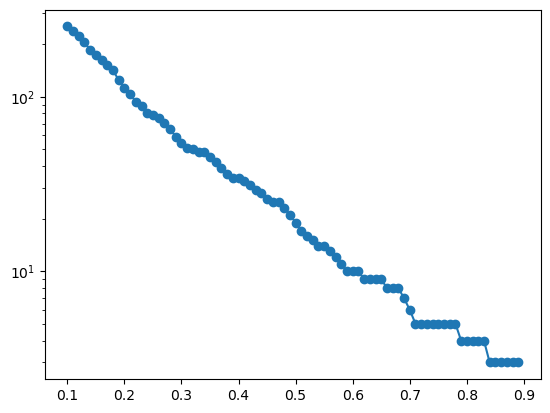

In [19]:
plt.plot(np.arange(0.1,0.9,0.01),n_detections,'-o')
plt.yscale("log")

In [20]:
n_detections[0]*1/np.exp(1)

92.70561917520347

In [21]:
h = pre.compute_h_param(im=im_c1,frame = im_c1.shape[0]//2,thresh=0.2)
h2 = pre.compute_h_param(im=im_c2,frame = im_c2.shape[0]//2,thresh=0.2)
#print(h,h2)

/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


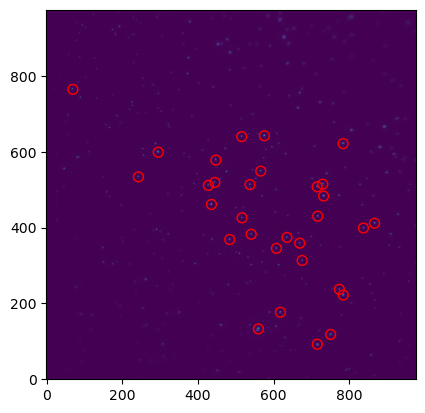

In [327]:
#d = pre.get_loc(im=im_c1,frame = im_c1.shape[0]//2,mins = 0. ,maxs = 2.0 ,thresh = 0.1)
#plt.imshow(im_c1[10,...],origin='lower')
#plt.scatter(d.x,d.y,edgecolors='r',facecolors='none',s=50)

In [22]:
l = []
for i in d.iloc:
    l.append(im_c1[10,int(i.y),int(i.x)])

NameError: name 'd' is not defined

In [326]:
l

[34034,
 24002,
 20782,
 25373,
 22254,
 13415,
 23618,
 17993,
 21347,
 19831,
 11394,
 19312,
 16952,
 15599,
 16491,
 20439,
 17766,
 16993,
 11666,
 8503,
 8759,
 16967,
 10814,
 12449,
 13513,
 15840,
 13452,
 11070,
 14001,
 14009,
 14529]

(array([3., 7., 5., 6., 4., 3., 2., 0., 0., 1.]),
 array([ 8503. , 11056.1, 13609.2, 16162.3, 18715.4, 21268.5, 23821.6,
        26374.7, 28927.8, 31480.9, 34034. ]),
 <BarContainer object of 10 artists>)

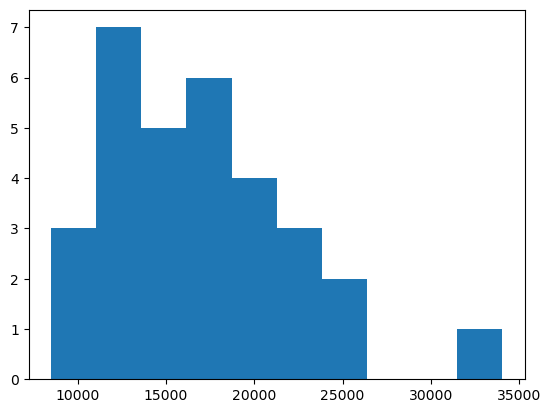

In [318]:
plt.hist(l)

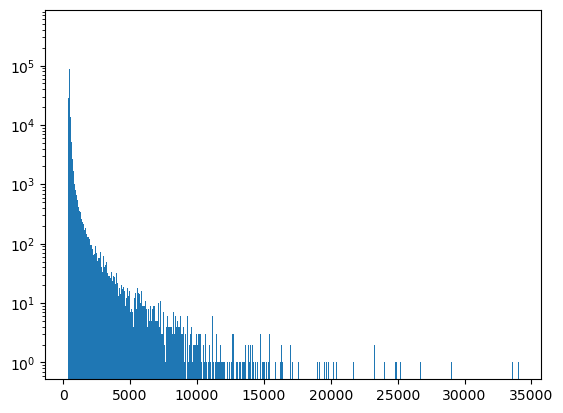

In [308]:
plt.hist(im_c1[im_c1.shape[0]//2].flatten(),bins=1000)
#plt.xscale("log")
plt.yscale("log")
plt.show()

In [24]:
print(h2)

2860.9272222013706


In [23]:
im_c1 = np.expand_dims(im_c1, axis=0)
im_c2 = np.expand_dims(im_c2, axis=0)

In [26]:
detections = det.hmax_3D(raw_im= im_c1,frame=0,sd=h,n = 1,thresh = 0.5,threads = 20)
detections_temp = det.hmax_3D(raw_im= im_c2,frame=0,sd=h2,n = 1,thresh = 0.5,threads = 20)

Runtime


In [71]:
detections['channel'] = 1
detections_temp['channel'] = 2

detections_comb = pd.concat([detections, detections_temp])

In [72]:
detections_comb

,x,y,z,sd_fit_x,sd_fit_y,sd_fit_z,frame,channel
0,708.222770,422.079872,10.377581,0.031563,0.031484,0.041224,0,1
1,288.939964,620.605458,10.099374,0.030440,0.029604,0.033908,0,1
2,590.265735,879.378350,10.705303,0.033320,0.033786,0.039775,0,1
3,232.229646,393.233188,9.030689,0.029383,0.029395,0.032509,0,1
4,837.413903,398.861509,9.939827,0.036808,0.034225,0.040400,0,1
...,...,...,...,...,...,...,...,...
356,60.114278,855.096758,10.364890,0.034878,0.034864,0.041377,0,2
357,590.241011,878.391111,11.418134,0.032621,0.032491,0.049128,0,2
358,296.253681,753.017895,9.761588,0.038870,0.039308,0.042901,0,2
359,79.506742,241.932001,8.093431,0.032850,0.028746,0.030882,0,2


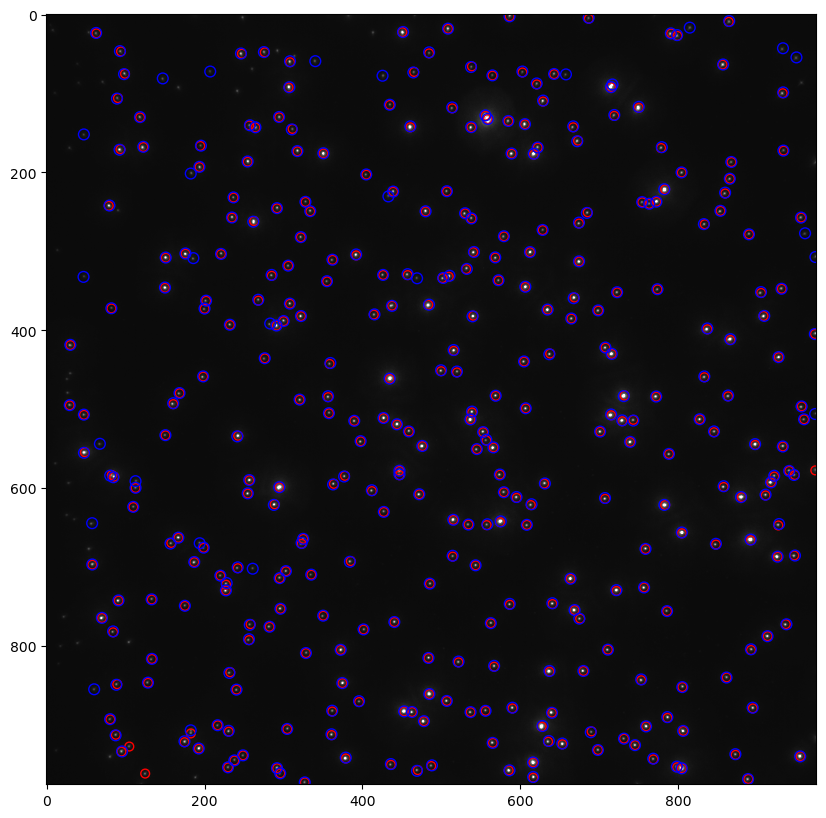

In [73]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(im_c1[0, :, ...],axis=0), cmap='gray', vmin=0, vmax=10000)
plt.scatter(detections_comb[detections_comb.channel == 1]['x'],detections_comb[detections_comb.channel == 1]['y'], edgecolors='r',facecolors='none' ,s=40)
plt.scatter(detections_comb[detections_comb.channel == 2]['x'],detections_comb[detections_comb.channel == 2]['y'], edgecolors='blue',facecolors='none' ,s=60)

# Matching

In [74]:
detections_comb['x'] = detections_comb['x']*met.voxel_size()[0]
detections_comb['y'] = detections_comb['y']*met.voxel_size()[1]
detections_comb['z'] = detections_comb['z']*met.voxel_size()[2]

In [75]:
detections_f = detections_comb#.query('x > 32 and x < 84 and y > 32 and y < 84')

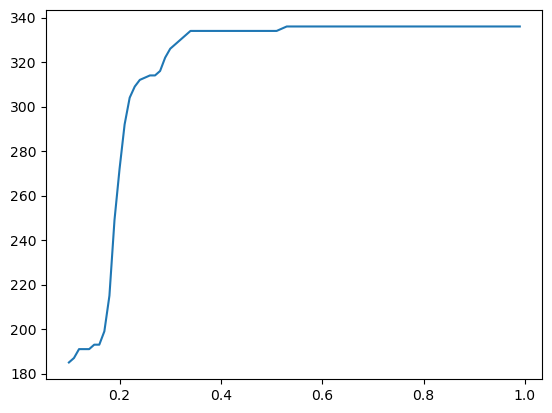

In [79]:
cutoff=np.arange(0.1,1,0.01)
n_matched=[]
for c in cutoff:
    matched = cor.assign_closest(detections_f[detections_f.channel ==1],detections_f[detections_f.channel ==2],c)
    n_matched.append(len(matched))
plt.plot(cutoff,n_matched)

In [106]:
matched = cor.assign_closest(detections_f[detections_f.channel ==1],detections_f[detections_f.channel ==2],0.2)

In [107]:
len(matched)

272

In [108]:
detections_1 = detections_f[detections_f.channel == 1].copy()
detections_2 = detections_f[detections_f.channel == 2].copy()

In [110]:
for i in matched:
    detections_1.loc[i[0],'dx'] = i[2]
    detections_1.loc[i[0],'dy'] = i[3]
    detections_1.loc[i[0],'dz'] = i[4]

In [111]:
detections_1.dropna(inplace=True, axis=0)

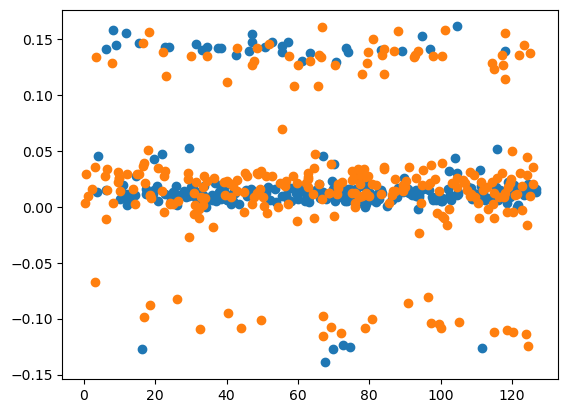

In [112]:
dx=detections_1["dx"].values
x=detections_1["x"]
plt.scatter(detections_1["x"],detections_1["dx"].values)
plt.scatter(detections_1["y"],detections_1["dy"].values)
#plt.scatter(detections_1["z"],detections_1["dz"].values)

In [113]:
big_error=detections_1[np.abs(detections_1["dy"].values)>0.1]


In [114]:
big_error

,x,y,z,sd_fit_x,sd_fit_y,sd_fit_z,frame,channel,dx,dy,dz
2,76.734546,114.319186,2.141061,0.033320,0.033786,0.039775,0.0,1.0,0.003214,0.128341,-0.142566
4,108.863807,51.851996,1.987965,0.036808,0.034225,0.040400,0.0,1.0,0.006815,0.146031,-0.112898
5,74.689900,83.636214,2.096367,0.054118,0.060800,0.060062,0.0,1.0,-0.125258,0.135823,0.062420
11,31.546175,69.379482,2.002439,0.027560,0.027607,0.032496,0.0,1.0,0.145744,-0.107631,0.038537
12,61.141031,124.474173,2.172378,0.036605,0.034421,0.041889,0.0,1.0,0.130370,-0.124074,0.052846
...,...,...,...,...,...,...,...,...,...,...,...
319,6.287296,72.105239,1.847956,0.047927,0.042060,0.048622,0.0,1.0,0.141135,-0.112535,0.054950
321,56.523316,59.988924,2.032726,0.024400,0.026946,0.033705,0.0,1.0,0.010930,0.126885,-0.103640
328,121.776249,100.435949,2.446049,0.038500,0.037929,0.046176,0.0,1.0,0.002118,0.135032,-0.123892
334,38.523777,97.904558,2.004392,0.034963,0.034407,0.038693,0.0,1.0,0.015876,0.135328,-0.130874


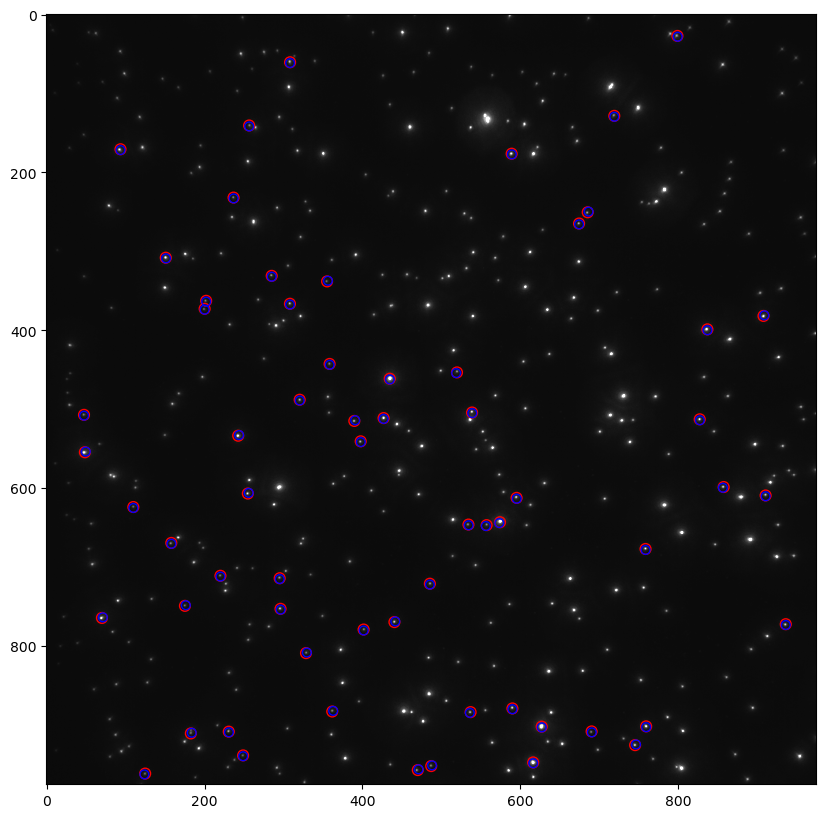

In [115]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(im_c1[0, :, ...],axis=0), cmap='gray', vmin=0, vmax=10000)
plt.scatter(big_error['x']/met.voxel_size()[0],big_error['y']/met.voxel_size()[1], edgecolors='r',facecolors='none' ,s=60)
plt.scatter(big_error['x']/met.voxel_size()[0]+big_error['dx']/met.voxel_size()[0],big_error['y']/met.voxel_size()[1]+big_error['dy']/met.voxel_size()[1], edgecolors='blue',facecolors='none' ,s=40)


In [39]:
detections_heat = detections_1[['x','y','dx']]
detections_heat = detections_heat.pivot(index='x',columns='y',values='dx')
detections_heat.fillna(0,inplace=True)

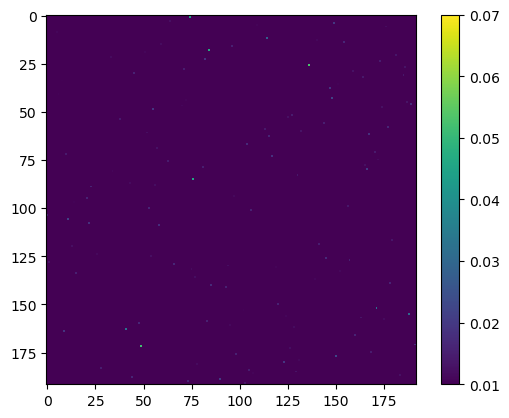

In [40]:
plt.imshow(detections_heat,vmin=0.01,vmax=0.07,interpolation='none')
plt.colorbar()

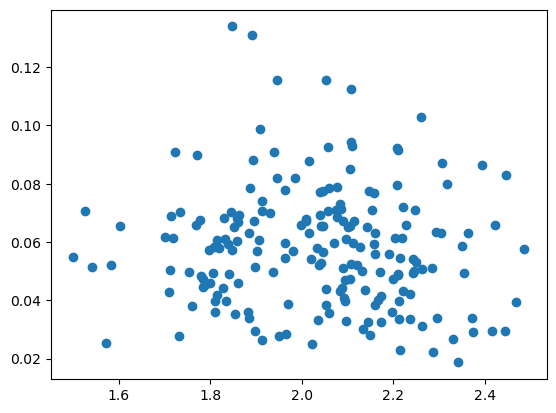

In [41]:
plt.scatter(detections_1["z"],detections_1["dz"].values)

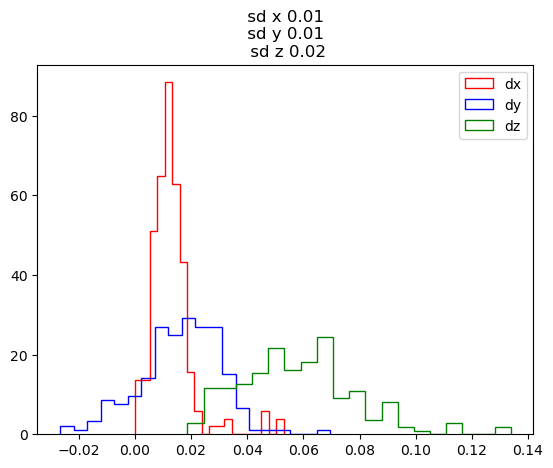

In [42]:
plt.hist(detections_1["dx"].values,histtype='step',color='r',bins=20,density=True,label='dx')
plt.hist(detections_1["dy"].values,histtype='step',color='b',bins=20,density=True,label='dy')
plt.hist(detections_1["dz"].values,histtype='step',color='g',bins=20,density=True,label='dz')
plt.title(f' sd x {np.std(detections_1["dx"].values):,.2f} \n sd y {np.std(detections_1["dy"].values):,.2f} \n sd z {np.std(detections_1["dz"].values):,.2f}')
plt.legend()
plt.show()

In [348]:
d=np.sqrt(detections_1["dx"].values**2+detections_1["dy"].values**2+detections_1["dz"].values**2)
print(np.std(d))

0.05555091773066076


# Multiple movies

In [159]:
df_comb = []
for path in tqdm(glob('/tungstenfs/scratch/ggiorget/nessim/2_color_imaging/localization_precision_estimation/runs/20240425_beads/*.csv')):
    df_temp = pd.read_csv(path)
    df_temp['run'] = path.split('/')[-1].split('.')[0]
    df_comb.append(df_temp)

df_comb = pd.concat(df_comb)

100%|██████████| 10/10 [00:00<00:00, 57.26it/s]


In [160]:
df_comb

,Unnamed: 0,x,y,z,sd_fit_x,sd_fit_y,sd_fit_z,frame,channel,dx,dy,dz,run
0,0,39.544718,52.094789,2.004156,0.030562,0.029426,0.034127,0.0,1.0,0.010890,0.026147,0.056132,detections_20240425_B2_100ms_7%laser_nd004
1,1,15.709265,95.076455,2.232823,0.027845,0.028715,0.035265,0.0,1.0,0.008679,0.015640,0.047716,detections_20240425_B2_100ms_7%laser_nd004
2,3,26.558451,106.984689,2.248472,0.033709,0.032871,0.039257,0.0,1.0,0.009411,0.014154,0.039563,detections_20240425_B2_100ms_7%laser_nd004
3,4,75.130859,16.094377,2.012489,0.037168,0.036731,0.044117,0.0,1.0,0.003968,0.035756,0.074003,detections_20240425_B2_100ms_7%laser_nd004
4,5,16.164762,26.907545,1.804013,0.035738,0.033696,0.043228,0.0,1.0,0.011199,0.040937,0.030470,detections_20240425_B2_100ms_7%laser_nd004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,233,18.832298,66.030206,2.028297,0.029848,0.030020,0.034913,0.0,1.0,0.021041,0.056157,0.069620,detections_20240425_B2_100ms_7%laser_nd007
193,234,53.312095,101.495232,2.195866,0.032173,0.031168,0.035857,0.0,1.0,0.021602,-0.013785,0.095108,detections_20240425_B2_100ms_7%laser_nd007
194,236,13.749126,17.578983,1.888359,0.032550,0.033959,0.058479,0.0,1.0,0.023086,0.019888,0.023919,detections_20240425_B2_100ms_7%laser_nd007
195,238,54.932716,78.453836,2.227756,0.033974,0.033949,0.042446,0.0,1.0,0.018835,0.015273,0.047976,detections_20240425_B2_100ms_7%laser_nd007


In [163]:
df_drop=df_comb[np.abs(df_comb["dx"].values)<0.12]
df_drop=df_drop[np.abs(df_drop["dy"].values)<0.12]
df_drop=df_drop[np.abs(df_drop["dz"].values)<0.2]

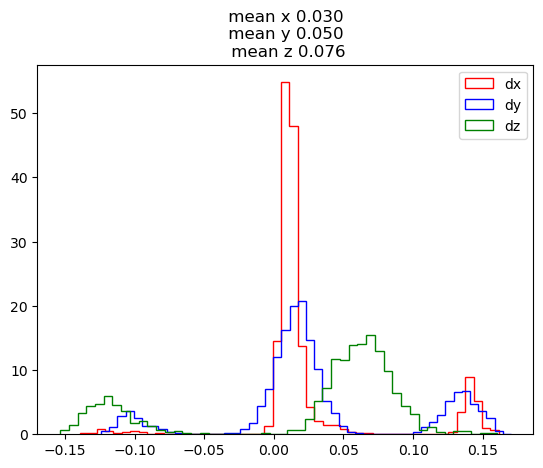

In [164]:
plt.hist(df_comb["dx"],histtype='step',color='r',bins=50,density=True,label='dx')
plt.hist(df_comb["dy"],histtype='step',color='b',bins=50,density=True,label='dy')
plt.hist(df_comb["dz"],histtype='step',color='g',bins=50,density=True,label='dz')
plt.title(f' mean x {np.mean(np.sqrt(df_comb["dx"].values**2)):,.3f} \n mean y {np.mean(np.sqrt(df_comb["dy"].values**2)):,.3f} \n mean z {np.mean(np.sqrt(df_comb["dz"].values**2)):,.3f}')
plt.legend()
plt.show()

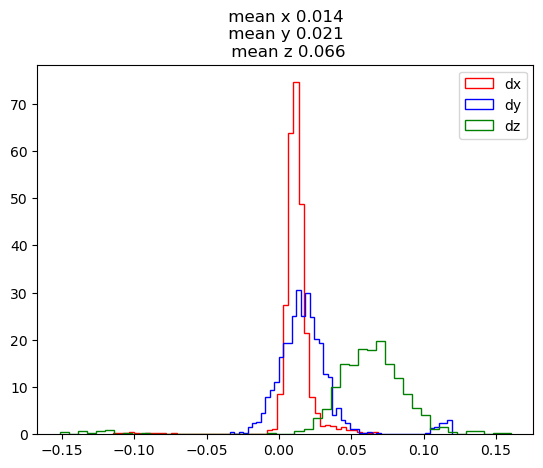

In [165]:
plt.hist(df_drop["dx"],histtype='step',color='r',bins=50,density=True,label='dx')
plt.hist(df_drop["dy"],histtype='step',color='b',bins=50,density=True,label='dy')
plt.hist(df_drop["dz"],histtype='step',color='g',bins=50,density=True,label='dz')
plt.title(f' mean x {np.mean(np.sqrt(df_drop["dx"].values**2)):,.3f} \n mean y {np.mean(np.sqrt(df_drop["dy"].values**2)):,.3f} \n mean z {np.mean(np.sqrt(df_drop["dz"].values**2)):,.3f}')
plt.legend()
plt.show()

/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warni

Text(0.5, 1.0, 'dx colored by movie')

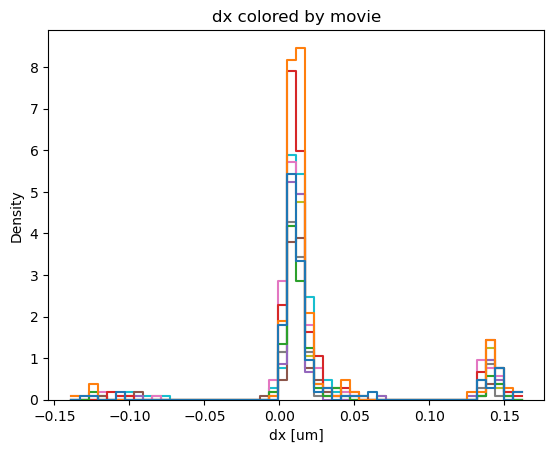

In [166]:

sns.histplot(data= df_comb,x='dx',element='step',fill=False,hue='run',bins=50,stat='density',label='dx',legend=False)
plt.xlabel('dx [um]')
plt.title('dx colored by movie')

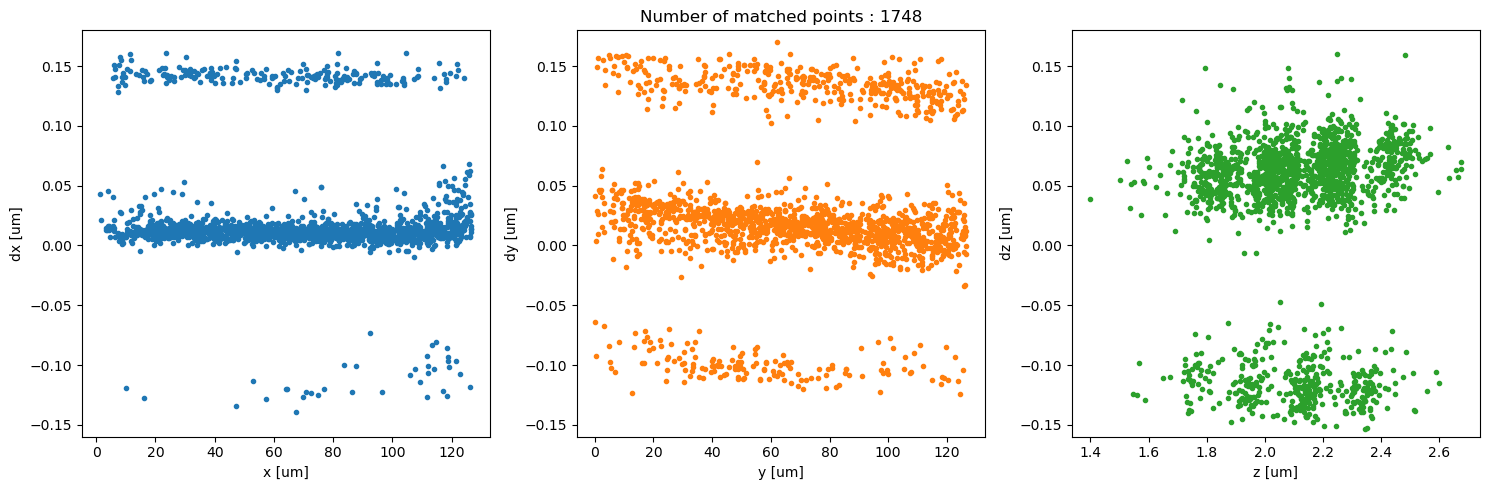

In [167]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(df_comb['x'],df_comb['dx'],'.')
ax[0].set_xlabel('x [um]')
ax[0].set_ylabel('dx [um]')

ax[1].plot(df_comb['y'],df_comb['dy'],'.',color='tab:orange')
ax[1].set_xlabel('y [um]')
ax[1].set_ylabel('dy [um]')
ax[2].plot(df_comb['z'],df_comb['dz'],'.',color='tab:green')
ax[2].set_xlabel('z [um]')
ax[2].set_ylabel('dz [um]')

ax[1].set_title(f'Number of matched points : {len(df_comb)}')

for a in ax:
    a.set_ylim(-0.16,0.18)

plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(df_drop['x'],df_drop['dx'],'.')
ax[0].set_xlabel('x [um]')
ax[0].set_ylabel('dx [um]')

ax[1].plot(df_drop['y'],df_drop['dy'],'.',color='tab:orange')
ax[1].set_xlabel('y [um]')
ax[1].set_ylabel('dy [um]')
ax[2].plot(df_drop['z'],df_drop['dz'],'.',color='tab:green')
ax[2].set_xlabel('z [um]')
ax[2].set_ylabel('dz [um]')

ax[1].set_title(f'Number of matched points : {len(df_comb)}')

for a in ax:
    a.set_ylim(-0.16,0.18)

plt.tight_layout()
plt.show()

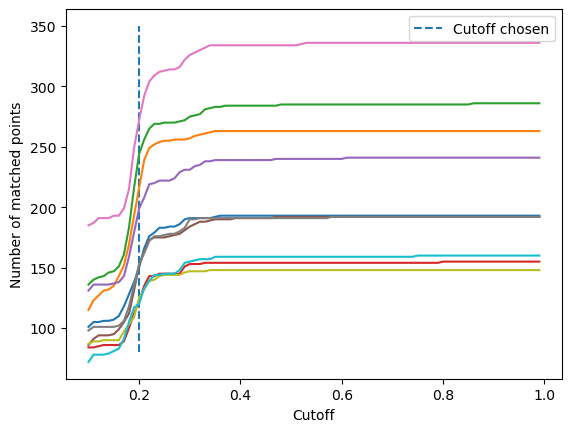

In [12]:
n_match = np.zeros((90,len(glob('/tungstenfs/scratch/ggiorget/nessim/2_color_imaging/localization_precision_estimation/runs/20240425_beads/n_matched*'))))

# n_match.shape
for l,path in enumerate(glob('/tungstenfs/scratch/ggiorget/nessim/2_color_imaging/localization_precision_estimation/runs/20240425_beads/n_matched*')):
    n_match[:,l] = np.load(path)

plt.vlines(0.2,80,350,linestyles='dashed',label='Cutoff chosen')
plt.legend()
for i in n_match.T:
    plt.plot(np.arange(0.1,1,0.01),i)


plt.ylabel('Number of matched points')
plt.xlabel('Cutoff')
plt.show()

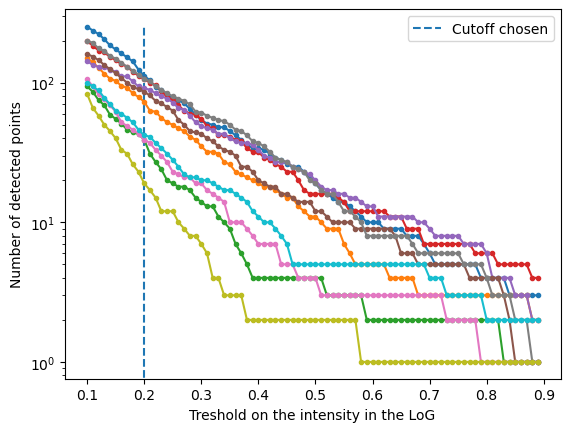

In [13]:
n_detect = np.zeros((80,len(glob('/tungstenfs/scratch/ggiorget/nessim/2_color_imaging/localization_precision_estimation/runs/20240425_beads/n_detections*'))))

# n_match.shape
for l,path in enumerate(glob('/tungstenfs/scratch/ggiorget/nessim/2_color_imaging/localization_precision_estimation/runs/20240425_beads/n_detections*')):
    n_detect[:,l] = np.load(path)

plt.vlines(0.2,0,255,label='Cutoff chosen',linestyles='dashed')
plt.legend()
for i in n_detect.T:
    plt.plot(np.arange(0.1,0.9,0.01),i,'.-')


plt.ylabel('Number of detected points')
plt.yscale('log')

plt.xlabel('Treshold on the intensity in the LoG')
plt.show()

# Test correction

In [125]:
reference = df_drop[df_drop['run']==df_drop['run'].unique()[0]][['x','y','z']].values.T

In [127]:
moving = df_drop[df_drop['run']==df_drop['run'].unique()[0]][['x','y','z']].values.T + df_drop[df_drop['run']==df_drop['run'].unique()[0]][['dx','dy','dz']].values.T

In [128]:
R, t = cor.calculate_rototranslation_3D(reference.T,moving.T)

In [129]:
R

array([[ 9.99999961e-01, -1.32246329e-04,  2.47133029e-04],
       [ 1.32333395e-04,  9.99999929e-01, -3.52322105e-04],
       [-2.47086418e-04,  3.52354795e-04,  9.99999907e-01]])

In [130]:
t

array([[-0.00160956],
       [-0.02519622],
       [-0.06919412]])

In [131]:
moving_cor = np.dot(R,moving)+t

In [132]:
dx,dy,dz = reference - moving_cor

In [133]:
reference[0,:].shape

(105,)

In [134]:
print(np.std(dy),np.std(df_drop[df_drop['run']==df_drop['run'].unique()[0]]['dy']))

0.022890271189127356 0.023671114030657966


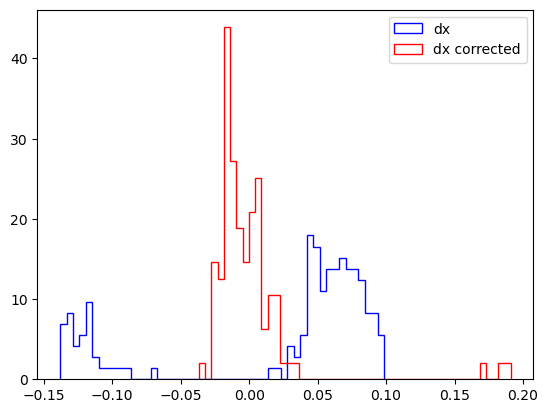

In [135]:
plt.hist(df_comb[df_comb['run']==df_comb['run'].unique()[0]]['dz'],histtype='step',color='blue',bins=50,density=True,label='dx')
plt.hist(dz,histtype='step',color='r',bins=50,density=True,label='dx corrected')
plt.legend()
plt.show()

In [136]:
np.std(np.sqrt(df_drop[df_drop['run']==df_drop['run'].unique()[0]]['dy']**2+df_drop[df_drop['run']==df_drop['run'].unique()[0]]['dx']**2+df_drop[df_drop['run']==df_drop['run'].unique()[0]]['dz']**2))

0.02605702775945631

In [137]:
np.std(np.sqrt(dy**2+dx**2+dz**2))

0.03656860675453817

# for all movies

In [139]:
reference = df_drop[['x','y','z']].values.T
moving = df_drop[['x','y','z']].values.T + df_drop[['dx','dy','dz']].values.T

R, t = cor.calculate_rototranslation_3D(reference.T,moving.T)

In [140]:
moving_cor = np.dot(R,moving)+t
dx,dy,dz = reference - moving_cor

In [ ]:
plt.plot(hist)

In [141]:
print(np.mean(np.sqrt(df_comb['dy']**2+df_comb['dx']**2)))
print(np.mean(np.sqrt(dy**2+dx**2)))

0.06501035293544606
0.017054994282616417


In [142]:
np.mean(np.sqrt(dz**2))

0.01910875473905805

In [143]:
print(np.mean(np.sqrt(dx**2)))
print(np.mean(np.sqrt(dy**2)))

0.006648040413734911
0.014515002707666357


In [149]:
len(dz)

1212

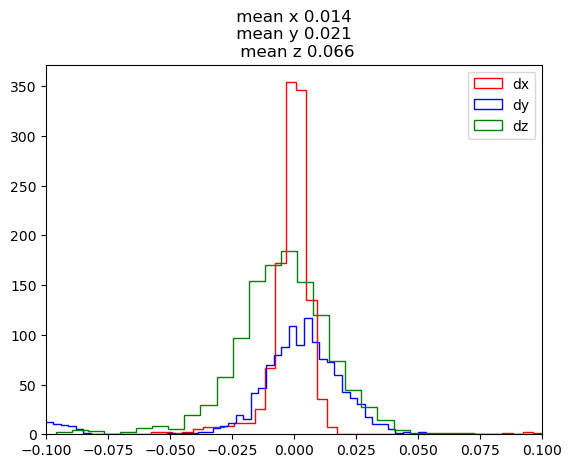

In [157]:
plt.hist(dx,histtype='step',color='r',bins=50,label='dx')
plt.hist(dy,histtype='step',color='b',bins=50,label='dy')
plt.hist(dz,histtype='step',color='g',bins=50,label='dz')
plt.title(f' mean x {np.mean(np.sqrt(df_drop["dx"].values**2)):,.3f} \n mean y {np.mean(np.sqrt(df_drop["dy"].values**2)):,.3f} \n mean z {np.mean(np.sqrt(df_drop["dz"].values**2)):,.3f}')
plt.legend()
plt.xlim(-0.1,0.1)
plt.show()

In [156]:
np.mean(dy)

-5.6164277482543084e-15